In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import cheby1, filtfilt, sosfiltfilt, decimate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [95]:
# Load data
data = loadmat('/Users/amarasekra/Documents/SEM 7/BSP/Paper Implementation/BCI_Comp_III_Wads_2004/Subject_A_Train.mat')
Signal = data['Signal']                                 # EEG signals
Flashing = data['Flashing']                             # Flashing (1 for flashing row/column, 0 otherwise)
StimulusCode = data['StimulusCode']                     # Indicates which row/column is flashing
StimulusType = data.get('StimulusType', np.array([]))   # 1 if target, 0 if not
TargetChar = data['TargetChar']

In [96]:
print("Data loaded successfully.")
print("Signal shape: ", Signal.shape)
print("Flashing shape: ", Flashing.shape)
print("StimulusCode shape: ", StimulusCode.shape)
print("StimulusType shape: ", StimulusType.shape)
print("TargetChar shape: ", TargetChar.shape)
print()

print("Length of the TargetChar Array (Number of Character Epochs):", len(TargetChar[0]))
print("TargetChar Array:", TargetChar[0])

Data loaded successfully.
Signal shape:  (85, 7794, 64)
Flashing shape:  (85, 7794)
StimulusCode shape:  (85, 7794)
StimulusType shape:  (85, 7794)
TargetChar shape:  (1,)

Length of the TargetChar Array (Number of Character Epochs): 85
TargetChar Array: EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI


Deciding how the data is arranged within each Character Epoch

In [97]:
StimulusCodeEpoch = StimulusCode[3]

print("Total sample length:", len(StimulusCodeEpoch))
print()

# Divide the data when the stimulus code changes
indices = np.where(np.diff(StimulusCodeEpoch))[0] + 1
indices = np.insert(indices, 0, 0)
indices = np.append(indices, len(StimulusCodeEpoch))

# Use a list to store the chunks
chunks = [StimulusCodeEpoch[indices[i]:indices[i+1]] for i in range(len(indices)-1)]

""" print("Data divided into", len(chunks), "chunks.")
print("Length of the chunks:", [len(chunk) for chunk in chunks])
print("Total sample length:", sum([len(chunk) for chunk in chunks]))
print()

print("First chunk:", chunks[0], "with a length of", len(chunks[0])) 
print()
print("Second chunk:", chunks[1], "with a length of", len(chunks[1]))
print()
print("Third chunk:", chunks[2], "with a length of", len(chunks[2]))
print()
print("Fourth chunk:", chunks[3], "with a length of", len(chunks[3]))   
print()
print("One before last chunk:", chunks[-2], "with a length of", len(chunks[-2]))
print()
print("Last chunk:", chunks[-1], "with a length of", len(chunks[-1])) """

uniqueCodes = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0,
    11: 0,
    12: 0
}

for chunk in chunks:
    if len(chunk) == 24:
        uniqueCode = np.unique(chunk)
        key = int(uniqueCode)
        value = uniqueCodes.get(key)
        uniqueCodes[key] = value + 1

print("Unique Codes:", uniqueCodes)

Total sample length: 7794

Unique Codes: {1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15, 10: 15, 11: 15, 12: 15}


/var/folders/9y/5k3l0ml16mn8y8y8y9ngs4hc0000gn/T/ipykernel_1121/3538432567.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  key = int(uniqueCode)


Data Preparation

In [98]:
# Dataset parameters
numChannel   = 64  # Number of EEG channels
numRowColumn = 12  # Number of Rows and Columns in the Character matrix
numSequence  = 15  # Number of sequences of intensification sets
samplingRate = 240 # Sampling rate of the EEG data

# Signal processing parameters
signalWindow = 160 # Data for 1s

In [99]:
# For each character epoch, store the signals in a dictionary
# The key is the 'character_row/column_stimulusType'
# The value is the 15 x signal_window matrix of signals

def divideSignal(focusedCharacter, signalArray, stimulusCodeArray, stimulusTypeArray):
    '''
    Takes the EEG signal, stimulus code, stimulus type for 
    a single character epoch and divides the signal into
    1s windows based on the stimulus code.
    '''

    # Dictionary to store the divided signal
    dividedSignal = dict()

    # Track how many entries have been added for each key
    indexTracker = dict()

    """ # 12 elements within the dictionary for the 12 rows/columns
    # A 3D array of numSequence x signalWindow x numChannel as the value
    for i in range(numRowColumn):
        key = focusedCharacter + '_' + str(i+1)
        dividedSignal[key] = np.zeros((numSequence, signalWindow, numChannel)) """

    # Divide the signal based on the stimulus code
    for j in range(numSequence * numRowColumn):
        start = j * 42
        end = start + signalWindow
        #print("Start:", start)
        #print("End:", end)

        # Get the corresponding stimulus code and type
        currentStimulusCode = int(stimulusCodeArray[start])
        #print("Current stimulus code:", currentStimulusCode)
        currentStimulusType = int(stimulusTypeArray[start])
        #print("Current stimulus type:", currentStimulusType)

        currentKey = focusedCharacter + '_' + str(currentStimulusCode) + '_' + str(currentStimulusType)
        #print("Current key:", currentKey)

        # If the key is not in the dictionary, add it
        if currentKey not in dividedSignal:
            #print("Key not in dictionary.")
            dividedSignal[currentKey] = np.zeros((numSequence, signalWindow, numChannel))
            indexTracker[currentKey] = 0
        #print()
        # Append the signal segment to the 3D array
        dividedSignal[currentKey][indexTracker[currentKey], :, :]  = signalArray[start:end]

        # Increment the index for the current key
        indexTracker[currentKey] += 1

    return dividedSignal

In [100]:
# Dictionary to store the divided signal for each character epoch
dividedSignal = dict()

# For the first character epoch, divide the signal
currentCharacterEpoch = 0
focusedCharacter = TargetChar[0][currentCharacterEpoch]
signalArray = Signal[currentCharacterEpoch]
stimulusCodeArray = StimulusCode[currentCharacterEpoch]
stimulusTypeArray = StimulusType[currentCharacterEpoch]

print("Focused Character:", focusedCharacter)
print("Signal Array Shape:", signalArray.shape)
print("Stimulus Code Array Shape:", stimulusCodeArray.shape)
print("Stimulus Type Array Shape:", stimulusTypeArray.shape)
print("Stimulus code array:", stimulusCodeArray)
print("Stimulus type array:", stimulusTypeArray)
print()

dividedSignal = divideSignal(focusedCharacter, signalArray, stimulusCodeArray, stimulusTypeArray)

print("Shape of the divided signal dictionary:" , len(dividedSignal))
print("Keys in the divided signal dictionary:", dividedSignal.keys())
print("Shape of the first key:", dividedSignal[list(dividedSignal.keys())[0]].shape)
print()

Focused Character: E
Signal Array Shape: (7794, 64)
Stimulus Code Array Shape: (7794,)
Stimulus Type Array Shape: (7794,)
Stimulus code array: [12. 12. 12. ...  0.  0.  0.]
Stimulus type array: [0. 0. 0. ... 0. 0. 0.]

Shape of the divided signal dictionary: 12
Keys in the divided signal dictionary: dict_keys(['E_12_0', 'E_11_0', 'E_3_0', 'E_10_0', 'E_9_0', 'E_7_1', 'E_8_0', 'E_2_0', 'E_6_0', 'E_5_1', 'E_4_0', 'E_1_0'])
Shape of the first key: (15, 160, 64)



Signal 1 shape: (160, 64)
Signal 2 shape: (160, 64)


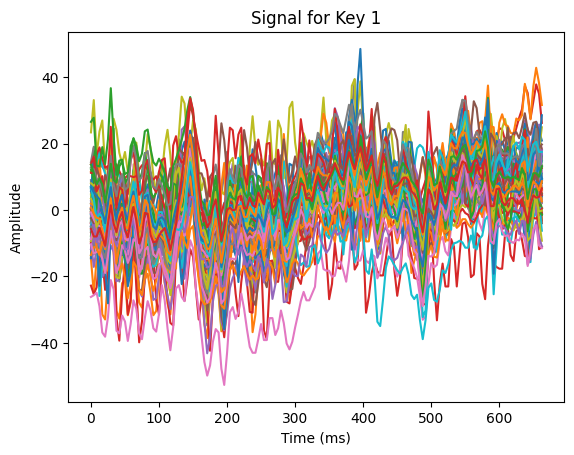

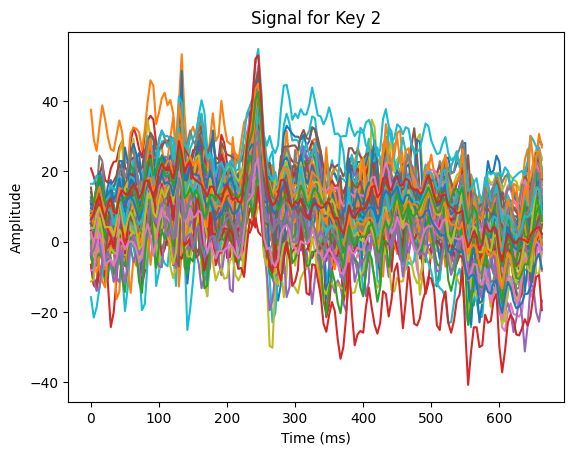

In [101]:
# Plot the first channel of the first key
key1 = 'E_7_1'
key2 = 'E_11_0'

plottingChannel = 10

signal1 = dividedSignal[key1][1, :, :]
signal2 = dividedSignal[key2][1, :, :]

print("Signal 1 shape:", signal1.shape)
print("Signal 2 shape:", signal2.shape)

time = np.arange(0, signalWindow) / samplingRate * 1000  # Convert to ms

plt.figure()
plt.plot(time, signal1)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Signal for Key 1')
plt.show()

plt.figure()
plt.plot(time, signal2)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Signal for Key 2')
plt.show()



In [102]:
def signalFiletringAndDecimation1(signal, samplingRate):
    '''
    Filter the signal using a bandpass filter and decimate it.
    8-order Chebyshev Type I filter with a passband of 0.1-10 Hz.
    Decimate the signal according to the high cutoff frequency.
    '''
    
    # Filter parameters
    lowCutoff = 0.1
    highCutoff = 10
    filterOrder = 5
    nyquist = 0.5 * samplingRate

    # Normalize the cutoff frequencies
    low = lowCutoff / nyquist
    high = highCutoff / nyquist

    # Chebyshev Type I filter
    b, a = cheby1(filterOrder, 1, [low, high], btype='band')
    
    # Padding the signal with reflection to mitigate transient effects
    padLength = 30
    paddedSignal = np.pad(signal, pad_width=padLength, mode='reflect')
    
    filteredPaddedSignal = filtfilt(b, a, paddedSignal)
    filteredSignal = filteredPaddedSignal[padLength:-padLength]

    # Decimate the signal
    decimationFactor = int(samplingRate / (2 * highCutoff))
    decimatedSignal = decimate(filteredSignal, decimationFactor)

    return filteredSignal, filteredPaddedSignal, decimatedSignal

In [103]:
def signalFilteringAndDecimation2(signal, samplingRate):
    '''
    Filter and decimate a (160, 64) signal.
    Uses an 8th-order Chebyshev Type I bandpass filter with a passband of 0.1-10 Hz.
    Decimates according to the high cutoff frequency.
    '''
    
    # Filter parameters
    lowCutoff = 0.1
    highCutoff = 10
    filterOrder = 5
    nyquist = 0.5 * samplingRate

    # Normalize the cutoff frequencies
    low = lowCutoff / nyquist
    high = highCutoff / nyquist

    # Chebyshev Type I filter coefficients
    b, a = cheby1(filterOrder, 1, [low, high], btype='band')
    
    # Padding length to mitigate edge effects
    padLength = 30
    
    # List to store decimated channels
    decimatedSignals = []

    # Initialize an array for the filtered signal with the original shape
    filteredSignal = np.zeros_like(signal)

    # Process each channel independently
    for channel in range(signal.shape[1]):
        # Extract single channel (160 samples)
        singleChannelSignal = signal[:, channel]

        # Pad the signal with reflection
        paddedSignal = np.pad(singleChannelSignal, pad_width=padLength, mode='reflect')

        # Filter the padded signal
        filteredPaddedSignal = filtfilt(b, a, paddedSignal)

        # Remove padding to get the filtered signal
        filteredChannelSignal = filteredPaddedSignal[padLength:-padLength]

        # Place filtered channel back into the filtered signal array
        filteredSignal[:, channel] = filteredChannelSignal

        # Decimate the filtered signal for this channel
        decimationFactor = int(samplingRate / (2 * highCutoff))
        decimatedChannelSignal = decimate(filteredChannelSignal, decimationFactor)

        # Append decimated channel result
        decimatedSignals.append(decimatedChannelSignal)

    # Stack decimated signals along the sample axis to form (14, 64)
    decimatedSignal = np.stack(decimatedSignals, axis=1)

    return filteredSignal, decimatedSignal

# Example usage:
# filteredSignal, decimatedSignal = signalFilteringAndDecimation(signal, samplingRate)


In [104]:
def signalFilteringAndDecimation3(signal, samplingRate):
    '''
    Filter and decimate a (160, 64) signal in a vectorized manner.
    Uses an 8th-order Chebyshev Type I bandpass filter with a passband of 0.1-10 Hz.
    Decimates according to the high cutoff frequency.
    '''
    
    # Filter parameters
    lowCutoff = 0.1
    highCutoff = 10
    filterOrder = 5  # 8th order Chebyshev Type I filter
    nyquist = 0.5 * samplingRate
    padLength = 30  # Padding length for edge effects
    
    # Normalize the cutoff frequencies
    low = lowCutoff / nyquist
    high = highCutoff / nyquist

    # Design filter using second-order sections
    sos = cheby1(filterOrder, 1, [low, high], btype='band', output='sos')
    
    # Reflect padding to all channels at once
    paddedSignal = np.pad(signal, ((padLength, padLength), (0, 0)), mode='reflect')

    # Apply zero-phase filtering in a batch over all channels
    filteredPaddedSignal = sosfiltfilt(sos, paddedSignal, axis=0)
    filteredSignal = filteredPaddedSignal[padLength:-padLength, :]

    # Decimation factor
    decimationFactor = int(samplingRate / (2 * highCutoff))

    # Decimate along the sample axis for all channels
    decimatedSignal = decimate(filteredSignal, decimationFactor, axis=0)

    return filteredSignal, decimatedSignal

Filtered Signal 1 Shape: (160, 64)
Decimated Signal 1 Shape: (14, 64)



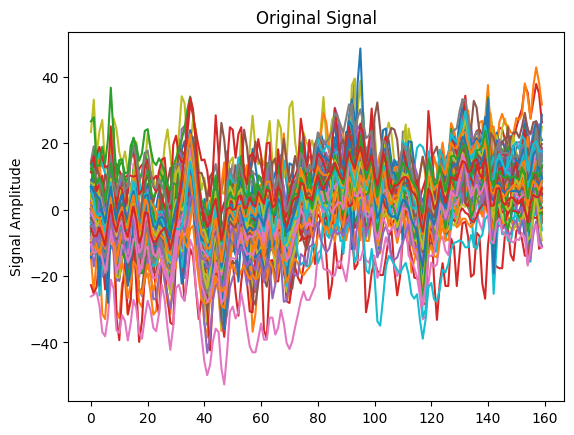

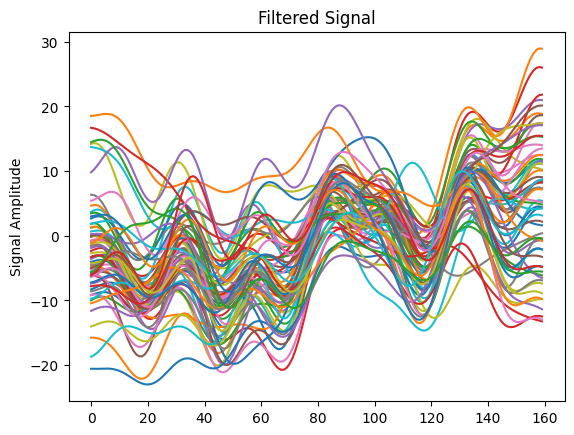

In [105]:
""" filteredSignal1, filteredPaddedSignal1, decimatedSignal1 = signalFilteringAndDecimation1(signal1, samplingRate)
filteredSignal2, filteredPaddedSignal2, decimatedSignal2 = signalFilteringAndDecimation1(signal2, samplingRate)

print("Filtered Signal 1 Shape:", filteredSignal1.shape)
print("Filtered Padded Signal 1 Shape:", filteredPaddedSignal1.shape)
print("Decimated Signal 1 Shape:", decimatedSignal1.shape)
print() """

""" filteredSignal1, decimatedSignal1 = signalFilteringAndDecimation2(signal1, samplingRate)
filteredSignal2, decimatedSignal2 = signalFilteringAndDecimation2(signal2, samplingRate)

print("Filtered Signal 1 Shape:", filteredSignal1.shape)
print("Decimated Signal 1 Shape:", decimatedSignal1.shape)
print() """

filteredSignal1, decimatedSignal1 = signalFilteringAndDecimation3(signal1, samplingRate)
filteredSignal2, decimatedSignal2 = signalFilteringAndDecimation3(signal2, samplingRate)

print("Filtered Signal 1 Shape:", filteredSignal1.shape)
print("Decimated Signal 1 Shape:", decimatedSignal1.shape)
print()

plt.figure()
plt.plot(signal1, label='Original Signal')
plt.ylabel('Signal Amplitude')
plt.title('Original Signal')
plt.show()

plt.figure()
plt.plot(filteredSignal1, label='Filtered Signal')
plt.ylabel('Signal Amplitude')
plt.title('Filtered Signal')
plt.show()

Test Signal Shape: (14, 64)
Concatenated Signal Shape: (896,)


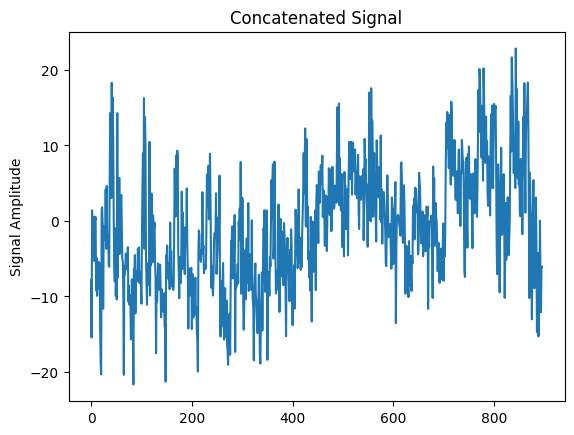

In [106]:
# Concatenation of the signal in all the channels
def concatenateChannels(signal):
    '''
    Concatenate the signal in all the channels.
    '''
    return np.concatenate(signal, axis=0)

testSignal = decimatedSignal1
print("Test Signal Shape:", testSignal.shape)

concatenatedSignal = concatenateChannels(testSignal)
print("Concatenated Signal Shape:", concatenatedSignal.shape)

plt.figure()
plt.plot(concatenatedSignal)
plt.ylabel('Signal Amplitude')
plt.title('Concatenated Signal')
plt.show()


Signal division for all epochs

In [107]:
# Divide the signal for all the character epochs
divide = []

# Take the first 75 character epochs for training
trainingEpochs = 75

# Take the last 10 character epochs for testing
testingEpochs = 10

for i in range(trainingEpochs):
    currentCharacterEpoch = i
    focusedCharacter = TargetChar[0][currentCharacterEpoch]
    signalArray = Signal[currentCharacterEpoch]
    stimulusCodeArray = StimulusCode[currentCharacterEpoch]
    stimulusTypeArray = StimulusType[currentCharacterEpoch]

    dividedSignal = divideSignal(focusedCharacter, signalArray, stimulusCodeArray, stimulusTypeArray)
    divide.append(dividedSignal)

print("Length of the divide list:", len(divide))
print("Keys in the first dictionary:", divide[0].keys())
print("Keys in the second dictionary:", divide[1].keys())
print(".")
print(".")
print(".")
print("Keys in the Last dictionary:", divide[-1].keys())

Length of the divide list: 75
Keys in the first dictionary: dict_keys(['E_12_0', 'E_11_0', 'E_3_0', 'E_10_0', 'E_9_0', 'E_7_1', 'E_8_0', 'E_2_0', 'E_6_0', 'E_5_1', 'E_4_0', 'E_1_0'])
Keys in the second dictionary: dict_keys(['A_7_1', 'A_1_1', 'A_10_0', 'A_6_0', 'A_3_0', 'A_4_0', 'A_5_0', 'A_9_0', 'A_2_0', 'A_11_0', 'A_12_0', 'A_8_0'])
.
.
.
Keys in the Last dictionary: dict_keys(['K_12_0', 'K_8_1', 'K_5_1', 'K_1_0', 'K_11_0', 'K_6_0', 'K_10_0', 'K_4_0', 'K_9_0', 'K_3_0', 'K_2_0', 'K_7_0'])


Make training data and labels

In [108]:
def makeDataAndLabels(Signal, StimulusCode, StimulusType, epochStart, epochEnd):
    '''
    Make the training data and labels for the signal.
    Training data is a 160 x 64 signal.
    Training label is 1 if the StimulusType is 1, -1 if 0.
    '''
    # List to store the training data and labels
    data = []
    labels = []

    # For each character epoch, divide the signal
    for characterEpoch in range(epochStart, epochEnd):
        signalArray = Signal[characterEpoch]
        stimulusCodeArray = StimulusCode[characterEpoch]
        stimulusTypeArray = StimulusType[characterEpoch]

        """ print("Signal Array Shape:", signalArray.shape)
        print("Stimulus Code Array Shape:", stimulusCodeArray.shape)
        print("Stimulus Type Array Shape:", stimulusTypeArray.shape)
        print() """

        # Divide the signal for the current character epoch
        for j in range(numSequence * numRowColumn):
            start = j * 42
            end = start + signalWindow

            # Get the corresponding stimulus type
            currentStimulusType = int(stimulusTypeArray[start])
            #print("Current stimulus type:", currentStimulusType)

            # Segment the signal for the current signal
            currentSignal = signalArray[start:end]
            currentLabel = 1 if currentStimulusType == 1 else -1

            # Append the signal segment to the training data
            data.append(currentSignal)
            labels.append(currentLabel)

            """ print("Training Data Shape:", currentSignal.shape)
            if currentLabel == 1:
                print("Training Labels Shape:", currentLabel) """

    return data, labels


In [109]:
# Make the training data and labels
trainingData, trainingLabels = makeDataAndLabels(Signal, StimulusCode, StimulusType, 0, trainingEpochs)

print("Length of the training data:", len(trainingData))
print("Shape of the first training data:", trainingData[0].shape)
print("Length of the training labels:", len(trainingLabels))
print("trainingLabels:", trainingLabels)
print()

# Make the testing data and labels
testingData, testingLabels = makeDataAndLabels(Signal, StimulusCode, StimulusType, trainingEpochs, trainingEpochs + testingEpochs)

print("Length of the testing data:", len(testingData))
print("Shape of the first testing data:", testingData[0].shape)
print("Length of the testing labels:", len(testingLabels))
print("testingLabels:", testingLabels)

Length of the training data: 13500
Shape of the first training data: (160, 64)
Length of the training labels: 13500
trainingLabels: [-1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -

Signal filtering and decimation

In [129]:
# Filter and decimate the training data
def filterAndDecimateData(trainingData, samplingRate):
    '''
    Filter and decimate the training data.
    '''
    filteredData = []
    decimatedData = []

    for signal in trainingData:
        filteredSignal, decimatedSignal = signalFilteringAndDecimation3(signal, samplingRate)
        filteredData.append(filteredSignal)
        decimatedData.append(decimatedSignal)

    return filteredData, decimatedData

In [132]:
# Filter and decimate the training data
filteredTrainingData, decimatedTrainingData = filterAndDecimateData(trainingData, samplingRate)

print("Length of the filtered training data:", len(filteredTrainingData))
print("Length of the decimated training data:", len(decimatedTrainingData))
print("Shape of the first filtered training data:", filteredTrainingData[0].shape)
print("Shape of the first decimated training data:", decimatedTrainingData[0].shape)
print()

# Filter and decimate the testing data
filteredTestingData, decimatedTestingData = filterAndDecimateData(testingData, samplingRate)

print("Length of the filtered testing data:", len(filteredTestingData))
print("Length of the decimated testing data:", len(decimatedTestingData))
print("Shape of the first filtered testing data:", filteredTestingData[0].shape)
print("Shape of the first decimated testing data:", decimatedTestingData[0].shape)

Length of the filtered training data: 13500
Length of the decimated training data: 13500
Shape of the first filtered training data: (160, 64)
Shape of the first decimated training data: (14, 64)

Length of the filtered testing data: 1800
Length of the decimated testing data: 1800
Shape of the first filtered testing data: (160, 64)
Shape of the first decimated testing data: (14, 64)


Partitioning the data for training the individual SVMs

In [151]:
def partitionData(data, labels, num_partitions=15):
    '''
    Partition the training data and labels into num_partitions.
    '''
    partition_size = len(data) // num_partitions
    partitions = [
        (data[i * partition_size: (i + 1) * partition_size],
         labels[i * partition_size: (i + 1) * partition_size])
        for i in range(num_partitions)
    ]

    return partitions

In [152]:
# Partition the data
# partitions = partitionData(vectorizedTrainingData, trainingLabels)
partitions = partitionData(decimatedTrainingData, trainingLabels)

print("Length of the partitions:", len(partitions))
print("Length of the first partition data:", len(partitions[0][0]))
print("Shape of the first partition data:", partitions[0][0][0].shape)
print("Length of the first partition labels:", len(partitions[0][1]))


Length of the partitions: 15
Length of the first partition data: 900
Shape of the first partition data: (14, 64)
Length of the first partition labels: 900


Vectorizing the 2D training data

In [153]:
def concatenateData(data):
    '''
    Concatenate the data in all the channels.
    '''
    concatenatedData = []

    for i in range(len(data)):
        concatenatedData.append(concatenateChannels(data[i]))
        
    return concatenatedData

In [159]:
# Concatenate the partititoned decimated training data for all the partitions
vectorizedPartitions = [(concatenateData(partitions[i][0]), partitions[i][1]) for i in range(len(partitions))]

print("Length of the vectorized partitions:", len(vectorizedPartitions))
print("Length of the first vectorized partition data:", len(vectorizedPartitions[0][0]))
print("Shape of the first vectorized partition data:", vectorizedPartitions[0][0][0].shape)
print("Length of the first vectorized partition labels:", len(vectorizedPartitions[0][1]))
print()

# Concatenate the decimated testing data
vectorizedTestingData = concatenateData(decimatedTestingData)

print("Length of the vectorized testing data:", len(vectorizedTestingData))
print("Shape of the first vectorized testing data:", vectorizedTestingData[0].shape)
print("Length of the testing labels:", len(testingLabels))

Length of the vectorized partitions: 15
Length of the first vectorized partition data: 900
Shape of the first vectorized partition data: (896,)
Length of the first vectorized partition labels: 900

Length of the vectorized testing data: 1800
Shape of the first vectorized testing data: (896,)
Length of the testing labels: 1800


Training the SVMs

In [155]:
def trainSVMs(partitions):
    '''
    Train a linear SVM for each partition.
    '''
    # List to store the classifiers
    classifiers = []

    for data, labels in partitions:
        svm = SVC(kernel='linear', C=1.0)  # Using linear kernel as specified in the text
        svm.fit(data, labels)
        classifiers.append(svm)

    return classifiers

In [ ]:
def computeCcs(trueLabels, predictedLabels):
    '''
    Compute the Correct Classification Rate (CCR).
    '''
    tn, fp, fn, tp = confusion_matrix(trueLabels, predictedLabels).ravel()
    score = tp / (tp + fp + fn)

    return score

In [ ]:
def recursiveChannelElimination(partition, testingData, testingLabels, numChannels=64, step=1):
    '''
    Perform recursive channel elimination to rank channels.

    Parameters:
    - partition: The training data and labels.
    - data: The feature matrix of shape (nSamples, nFeatures).
    - labels: The corresponding labels for the samples.
    - numChannels: The total number of channels in the dataset.
    - step: Number of channels to remove at each step (default is 4).

    Returns:
    - svm: The trained SVM model.
    - ranked_channels: A list of channels ranked from least to most important.
    '''
    # Initialize the list of all channels
    channels = list(range(numChannels))
    ranked_channels = []  # Store the order of channel elimination

    # Get the training data and labels
    data, labels = partition
    
    while channels:
        best_score = -np.inf
        channel_to_remove = None
        
        # Try removing each channel one at a time and evaluate
        for ch in channels:
            # Temporarily remove channel ch's features
            temp_data = np.delete(data, slice(ch * num_features_per_channel, 
                                              (ch + 1) * num_features_per_channel), axis=1)
            
            # Train the SVM
            svm = SVC(kernel="linear")  # Use linear SVM for simplicity
            svm.fit(temp_data, labels)
            
            # Evaluate the SVM on testing data (use a partitioned test set for validation)
            predictions = svm.predict(temp_data)
            score = accuracy_score(labels, predictions)  # or other score metric
            
            # Check if this is the best score so far
            if score > best_score:
                best_score = score
                channel_to_remove = ch
        
        # Add the selected channel to the ranked list and permanently remove it
        ranked_channels.append(channel_to_remove)
        channels.remove(channel_to_remove)
        
        # Optionally, remove multiple channels in each step
        if step > 1 and len(channels) >= step:
            additional_channels = ranked_channels[-(step - 1):]
            for ch in additional_channels:
                channels.remove(ch)
                ranked_channels.append(ch)

        print(f"Removed channel {channel_to_remove} with score {best_score}")
    
    return ranked_channels


In [160]:
# Train an ensemble of SVMs
svm_classifiers = trainSVMs(vectorizedPartitions)

print("Length of the SVM classifiers:", len(svm_classifiers))

Length of the SVM classifiers: 15


Test the accuracy of the Ensemble of SVMs on the testing data

In [161]:
# Test the SVMs on the testing data
svm_predictions = []
for svm in svm_classifiers:
    predictions = (svm.predict(vectorizedTestingData) + 1).astype(int)
    """ print("Predictions Shape:", predictions.shape)
    print("Predictions:", predictions)
    print() """
    svm_predictions.append(predictions)

# Convert list of predictions to a numpy array of shape (15, 1800)
svm_predictions = np.array(svm_predictions)

# Aggregate predictions using majority voting
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=svm_predictions)
final_predictions = (final_predictions * 2) - 1

accuracy = accuracy_score(testingLabels, final_predictions)

print(f"Ensemble SVM accuracy on test data: {accuracy * 100:.2f}%")

Ensemble SVM accuracy on test data: 80.22%


Predict the focused character for a single character epoch

In [162]:
# Dictionary to store the divided signal for the testing character epoch
dividedTestingSignal = dict()

# For the first character epoch, divide the signal
testingCharacterEpoch = -1
testingFocusedCharacter = TargetChar[0][testingCharacterEpoch]
testingSignalArray = Signal[testingCharacterEpoch]
testingStimulusCodeArray = StimulusCode[testingCharacterEpoch]
testingtimulusTypeArray = StimulusType[testingCharacterEpoch]

print("Focused Character:", testingFocusedCharacter)
print("Signal Array Shape:", testingSignalArray.shape)
print("Stimulus Code Array Shape:", testingStimulusCodeArray.shape)
print("Stimulus Type Array Shape:", testingtimulusTypeArray.shape)
print("Stimulus code array:", testingStimulusCodeArray)
print("Stimulus type array:", testingtimulusTypeArray)
print()

dividedTestingSignal = divideSignal(testingFocusedCharacter, testingSignalArray, testingStimulusCodeArray, testingtimulusTypeArray)

print("Shape of the divided signal dictionary:" , len(dividedTestingSignal))
print("Keys in the divided signal dictionary:", dividedTestingSignal.keys())
print("Shape of the first key:", dividedTestingSignal[list(dividedTestingSignal.keys())[0]].shape)
print()

filteredTestingSignal = dict()
decimatedTestingSignal = dict()

# Filter and decimate the testing signal
for key in dividedTestingSignal:
    filteredTestingSignal[key] = np.zeros((numSequence, signalWindow, numChannel))
    decimatedTestingSignal[key] = np.zeros((numSequence, 14, numChannel))
    for i in range(numSequence):
        signal = dividedTestingSignal[key][i, :, :]
        filteredSignal, decimatedSignal = signalFilteringAndDecimation3(signal, samplingRate)
        filteredTestingSignal[key][i, :, :] = filteredSignal
        decimatedTestingSignal[key][i, :, :] = decimatedSignal

print("Filtered Testing Signal Shape:", len(filteredTestingSignal))
print("Shape of the first filtered testing signal:", filteredTestingSignal[list(filteredTestingSignal.keys())[0]].shape)
print("Decimated Testing Signal Shape:", len(decimatedTestingSignal))
print("Shape of the first decimated testing signal:", decimatedTestingSignal[list(decimatedTestingSignal.keys())[0]].shape)
print()

# Concatenate the decimated testing signals
vectorizedTestingSignal = dict()

for key in decimatedTestingSignal:
    vectorizedTestingSignal[key] = np.zeros((numSequence, 14 * numChannel))
    for i in range(numSequence):
        signal = decimatedTestingSignal[key][i, :, :]
        vectorizedSignal = concatenateChannels(signal)
        vectorizedTestingSignal[key][i, :] = vectorizedSignal

print("Vectorized Testing Signal Shape:", len(vectorizedTestingSignal))
print("Shape of the first vectorized testing signal:", vectorizedTestingSignal[list(vectorizedTestingSignal.keys())[0]].shape)

Focused Character: I
Signal Array Shape: (7794, 64)
Stimulus Code Array Shape: (7794,)
Stimulus Type Array Shape: (7794,)
Stimulus code array: [3. 3. 3. ... 0. 0. 0.]
Stimulus type array: [1. 1. 1. ... 0. 0. 0.]

Shape of the divided signal dictionary: 12
Keys in the divided signal dictionary: dict_keys(['I_3_1', 'I_5_0', 'I_4_0', 'I_11_0', 'I_8_1', 'I_2_0', 'I_10_0', 'I_9_0', 'I_7_0', 'I_1_0', 'I_12_0', 'I_6_0'])
Shape of the first key: (15, 160, 64)

Filtered Testing Signal Shape: 12
Shape of the first filtered testing signal: (15, 160, 64)
Decimated Testing Signal Shape: 12
Shape of the first decimated testing signal: (15, 14, 64)

Vectorized Testing Signal Shape: 12
Shape of the first vectorized testing signal: (15, 896)


In [163]:
# Predict the testing decision scores using the ensemble of SVMs
svmDecisionScores = dict()

for key in vectorizedTestingSignal:
    rowColScore = []
    for i in range(numSequence):
        signal = vectorizedTestingSignal[key][i, :]
        signal_reshaped = signal.reshape(1, -1)

        # Calculate the decision score by each classifier in the ensemble
        svmScores = []
        for svm in svm_classifiers:
            # Decision function returns the signed distance to the hyperplane
            decisionFunctionValue = svm.decision_function(signal_reshaped)[0] 
            svmScores.append(decisionFunctionValue)
        # Average the scores over the ensemble
        finalScore = np.mean(svmScores)
        rowColScore.append(finalScore)

    # Average the predictions for the 15 sequences
    svmDecisionScores[key] = np.mean(rowColScore)

print("Length of the SVM Testing Predictions:", len(svmDecisionScores))
print("SVM Testing Predictions:", svmDecisionScores)
        

Length of the SVM Testing Predictions: 12
SVM Testing Predictions: {'I_3_1': -1.2367655811954519, 'I_5_0': -1.9375117299498967, 'I_4_0': -1.9998190817525543, 'I_11_0': -1.6889471319578726, 'I_8_1': -1.2788099493163176, 'I_2_0': -1.8783885130270124, 'I_10_0': -1.3991218539264354, 'I_9_0': -1.5349605059412474, 'I_7_0': -1.051891971779194, 'I_1_0': -2.5792225194049885, 'I_12_0': -2.453536015004872, 'I_6_0': -2.0123654131563344}


In [164]:
# Define the character matrix
characterMatrix = [
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
]

# Preduct the focused character
predictedValues = np.zeros(numRowColumn)
for key in svmDecisionScores:
    rowColumnValue = int(key.split('_')[1])
    predictedValues[rowColumnValue - 1] = svmDecisionScores[key]
print("Predicted Values for Rows:", predictedValues[6:])
print("Predicted Values for Columns:", predictedValues[:6])

# Predict the row/column
predictedRow = np.argmax(predictedValues[6:]) + 1
predictedColumn = np.argmax(predictedValues[:6]) + 1
print("Predicted Row:", predictedRow)
print("Predicted Column:", predictedColumn)

# Predict the focused character
predictedCharacter = characterMatrix[predictedRow - 7][predictedColumn - 1]
print("Predicted Character:", predictedCharacter)

Predicted Values for Rows: [-1.05189197 -1.27880995 -1.53496051 -1.39912185 -1.68894713 -2.45353602]
Predicted Values for Columns: [-2.57922252 -1.87838851 -1.23676558 -1.99981908 -1.93751173 -2.01236541]
Predicted Row: 1
Predicted Column: 3
Predicted Character: C
